<a href="https://colab.research.google.com/github/ntb-cicles/SMB-Linux-Windows/blob/main/Samba_com_a_controlador_de_domini_Versio_simplificada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONFIGURACIÓ DEL SERVIDOR**

## PAS 1: Instal·leu els paquets "samba", "smbclient" i "winbind" amb la comanda següent:

In [ ]:
sudo apt-get update
sudo apt-get install samba smbclient winbind

## PAS 2: Instal·leu i configureu "Kerberos"

Kerberos es tracta d'un protocol que serveix per a autenticar dos dispositius que es connecten entre si. No significa que vagi a autoritzar-los, sinó autenticar-los. La seva funció és identificar cada usuari mitjançant xifratge.

In [ ]:
sudo apt-get update
sudo apt-get install krb5-config

Kerberos us demana introduir 3 noms:

*   Reino de Kerberos: **EXEMPLE.COM**  # Tot en majúscules
*   Servidors de Kerberos que utilitzarem: **HOSTNAME.exemple.com**   # Tot en minúscules. Cal afegir el vostre hostname davant del nom del domini. 
*   Servidor administratiu de Kerberos que utilitzarem: **HOSTNAME.exemple.com**



Per exemple, si el meu **HOSTNAME** és "**servnil**":

In [ ]:
Reino de Kerberos: DAM.COM
Servidors de Kerberos que utilitzarem: **servnil.dam.com**
Servidor administratiu de Kerberos que utilitzarem: **servnil.dam.com**

Winbind us indica que vol canviar el vostre fitxer de configuració de SAMBA (smb.conf) per un altre nou. Accepteu-ho.

Si us heu equivocat en la configuració de kerberos (o la comanda no us ha demanat configurar res), utilitzeu la comanda següent per configurar Kerberos de nou:

In [ ]:
sudo dpkg-reconfigure krb5-config

## PAS 3: Modifiqueu el fitxer de hosts (assignació de noms en el propi servidor Ubuntu Server)

A mesura que la vostra màquina s'iniciï, haurà de conèixer l'assignació d'alguns noms d'amfitrió a adreces IP abans que es pugui fer referència al DNS. Aquesta assignació es manté al fitxer /etc/hosts. En absència d'un servidor de noms, qualsevol programa de xarxa del vostre sistema consulta aquest fitxer per determinar l'adreça IP que correspon a un nom d'amfitrió.

In [ ]:
sudo nano /etc/hosts

In [ ]:
IPAddress       Hostname    		   Alias
127.0.0.1			  localhost	 	       
127.0.1.1			  servnil


Heu d'afegir una nova línia en aquest fitxers /etc/hosts, després de la resta de línies, amb la **IP de la vostra màquina** servidor, el **nom del servidor de Kerberos**, i un **alias que li vulgueu donar**. Per exemple:

In [ ]:
IPAddress           Hostname    		    Alias
127.0.0.1			      localhost	 	       
# 127.0.1.1			      servnil
192.168.55.102		  servnil.dam.com	 	  servnil

A més, de moment, cal que comenteu la segona línia (la traducció de la IP "127.0.1.1)

## PAS 4: Assignar al Samba la tasca de controlador de domini (Configuració de Domain provision)

Feu còpia de seguretat de "smb.conf"

In [ ]:
cd /etc/samba
sudo mv smb.conf smb.conf.backup

Cal còpia de seguretat ja que farem una configuració de Samba, però no modificant directament el smb.conf, sinó utilitzant altres eines externes.

\

Per a que les eines externes modifiquin el smb.conf, cal NO TENIR CAP FITXER SMB.CONF, per això fem còpia de seguretat amb la comanda "mv" (cortar i pegar) i no amb "cp" (copiar y pegar).

\

Comencem configuració de samba amb comanda:

In [ ]:
sudo samba-tool domain provision

Deixar tots els valors per defecte, ja que ha detectat els valors del Realm que heu posat anteriorment. Si no us surt **[NOMREALM.COM]** desprès de **Realm**, proveu de donar enter sense escriure res i us dóna error, vol dir que heu configurat malament el fitxer de hosts.

*   Realm[EXAMPLE.COM]: 
*   Domain[EXAMPLE]
*   Server role[dc]: L'opció per defecte és un domain controller "dc", així que enter i endavant
*   DNS backend (SAMBA_INTERNAL, BIND9_FLATFILE, BIND9_DLZ, NONE [SAMBA_INTERNAL]: Agafar el DNS intern de SAMBA, el que està per defecte, així que enter i endavant
*   DNS forwarder IP address (write 'none' to disable forwarding) [127.0.0.53]:  **8.8.8.8**  # En aquest cas sí poseu un DNS real, per exemple, el servidor de DNS de Google, que és 8.8.8.8
*  Password: Per exemple, **123456A!** 


Deixeu tots els camps per defecte. Us hauria de sortir el nom de domini que heu posat anteriorment, DC (voleu que el servidor funcioni com a controlador de domini), i els DNS per defecte.

\

Només cal emplenar l'última opció, on cal posar una contrasenya per l'administrador del domini. Recordeu-la per més endavant!

## PAS 5: Configuració final del fitxer de hosts

Després d'assignar samba com a Controlador de Domini, ja podeu des-comentar la traducció de la IP "127.0.1.1":

In [ ]:
sudo nano /etc/hosts

In [ ]:
IPAddress           Hostname    		    Alias
127.0.0.1			      localhost	 	       
127.0.1.1			      servnil
192.168.55.102		  servnil.dam.com	 	  servnil

## PAS 6: Comprovacions finals abans d'habilitar el Directori Actiu

Desprès del pas anterior, hem de copiar la configuració de kerberos (krb5.conf) al directori **/etc/** :

In [ ]:
sudo cp /var/lib/samba/private/krb5.conf /etc/

Cal desactivar els 4 serveis següents abans de continuar (serveis estàndard de SAMBA):

In [ ]:
sudo systemctl disable --now smbd nmbd winbind systemd-resolved.service 

In [ ]:
sudo systemctl unmask samba-ad-dc.service 

In [ ]:
sudo systemctl enable --now samba-ad-dc.service

Comprovar que estem simulant un Active Directory de Windows amb el samba:

In [ ]:
sudo samba-tool domain level show

## PAS 7: Indicar quins servidors (IPs) utiltzarà el host per a fer resolució de DNS

El fitxer "resolv.conf" llista els servidors de noms que utilitza el sistema per a la resolució DNS. Si utilitzeu DHCP, aquest fitxer s'omple automàticament amb el registre DNS emès pel servidor DHCP.

Primer de tot, cal esborrar el link simbòlic següent, ja que hem de crear el nostre "**resolv.conf**" propi. Podeu fer una còpia de seguretat del fitxer original si voleu. 

In [ ]:
sudo rm /etc/resolv.conf
sudo nano /etc/resolv.conf

El fitxer "**resolv.conf**" conté els servidors DNS que volem utilitzar. Per aquesta pràctica, cal que hi poseu:

In [ ]:
nameserver 127.0.0.1

"nameserver" és un nom propi, ha d'estar escrit tal qual.

"127.0.0.1" és la IP de loopback, és a dir, el mateix servidor farà de DNS 

Si heu arribat fins aquí, qualsevol client que posi com a servidor DNS principal aquest servidor Ubuntu Server, podrà trobar els serveis de Directory Actiu.

# **CONFIGURACIÓ DEL CLIENT (Windows 10)**

## PAS 1: Tenir connexió al Servidor de Directori Actiu des del client Windows

Dins de les propietats de Windows, canviar les propietats de **l'adaptador en xarxa que estigui connectat a la mateixa xarxa que el vostre servidor de Directori Actiu** (és a dir, la xarxa que us permet connectar-vos entre màquines virtuals). 

\

En l'apartat IPv4 de la configuració de l'adaptador, cal posar com a DNS la IP de la màquina del Ubuntu Server. Trobareu aquest apartat en "**Configuración de red avanzada / Cambiar opciones del adaptador** si feu anar una nova versió de Windows.

El DNS preferit ha de ser el nostre servidor de Directori Actiu, és a dir, poseu la IP DEL SERVIDOR. Exemple:

In [ ]:
DNS Preferido: 192.168.55.102

És molt recomanable seleccionar l'opció "**comprovar configuración al salir**", ja que d'aquesta manera es comprovarà si el servidor de DNS funciona correctament o no. 

## PAS 2: Unir el client al Domini

Aneu a **Configuración / Sistema / Acerca de**. Llavors, a la part dreta, premeu la opció **Cambiar el nombre de este equipo (avanzado)**.

En la finestra veureu que hi ha un botó que serveix per canviar "**El nombre de este equipo o el dominio o grupo de trabajo**".

Obreu la finestra, i a nosatres ens interessa canviar el **Domini**. El Grup de Treball (Workgroup) el podeu deixar igual. 

Us demanarà usuari i contrasenya:

La contrasenya és la que heu posat en el "samba-tool domain provision". En el meu cas, era 123456A!

In [ ]:
usuari = administrator
contrasenya = 123456A!

El domini ha de ser el nom del vostre regne (domini) amb minúscules, per exemple:

In [ ]:
dam.com

Si després de carregar us surt un missatge "se unió correctamente al dominio dam.com" és que el vostre ordinador ja forma part del domini!!

## PAS 3: Entrar al SO Windows utilitzant un usuari del controlador de dominis SAMBA

Si reinicieu Windows després del pas 2, ja podreu fer login amb un usuari creat i gestionat per SAMBA. 

Els usuaris s'escriuen amb la sintaxi següent:

In [ ]:
Nombre de usuario = NOM_USUARI@NOM_DOMINI
Contrasenya = [la que hagueu posat a l'usuari]

Per exemple:

In [ ]:
Nombre de usuario = alicia@dam.com
Contrasenya = [la que hagueu posat a l'usuari]

Si encara no teniu cap usuari creat (més endavant s'explica com crear i gestionar usuaris) podeu provar d'entrar amb l'usuari administrador:

In [ ]:
Nombre de usuario = administrator@dam.com
Contrasenya = 123456A!

### Entenent perquè cal modificar el DNS preferit i altres configuracions anteriors

Ara us podeu donar compte de que formeu part, per exemple, del domini "**dam.com**". 

Necessitem que el DNS preferit sigui el que tenim a la nostra màquina virtual de Ubuntu Server, ja que el domini "**dam.com**" podria existir realment, i per tant si el nostre servidor DNS és un d'extern, tindriem la IP del servidor que guarda la pàgina web "**dam.com**" en comptes del nostre controlador de Dominis!

## PAS 4: Activar RSAT 

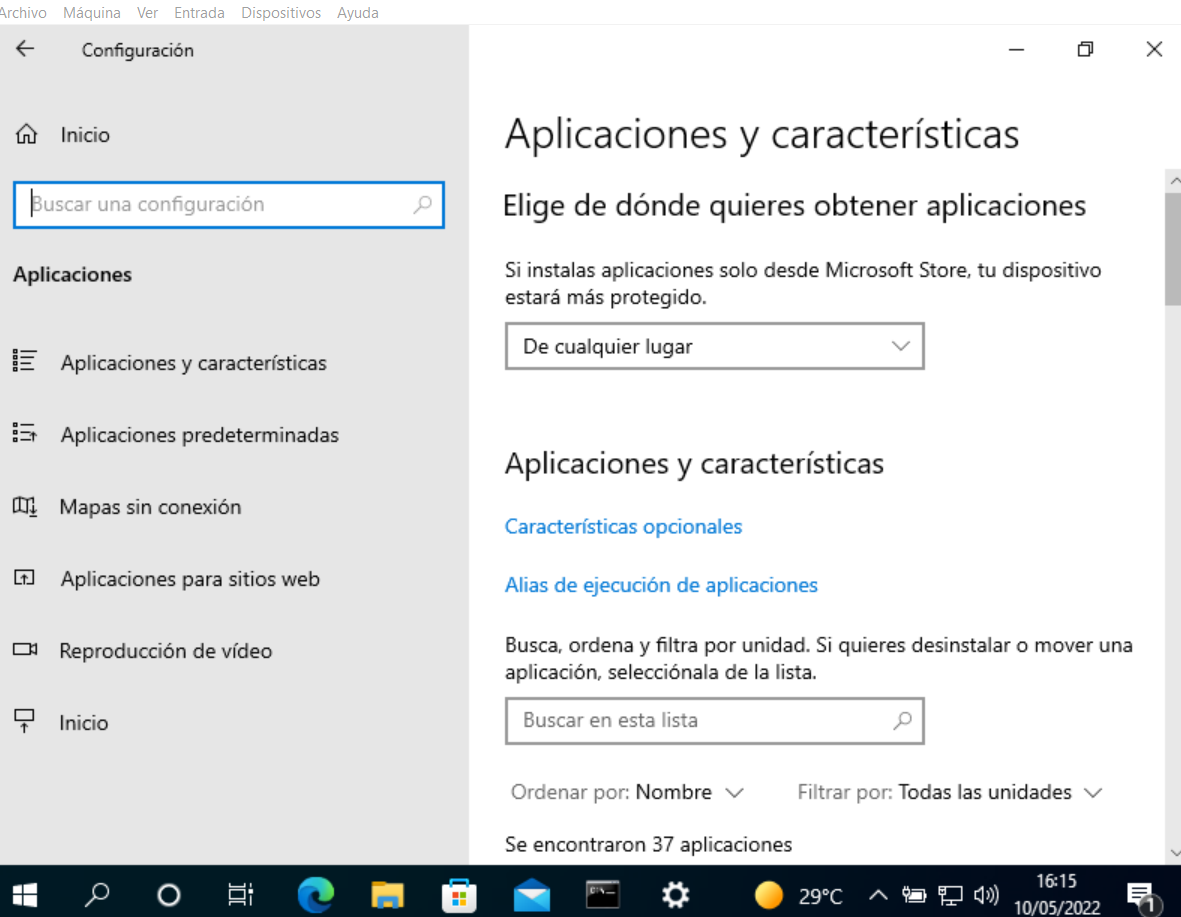

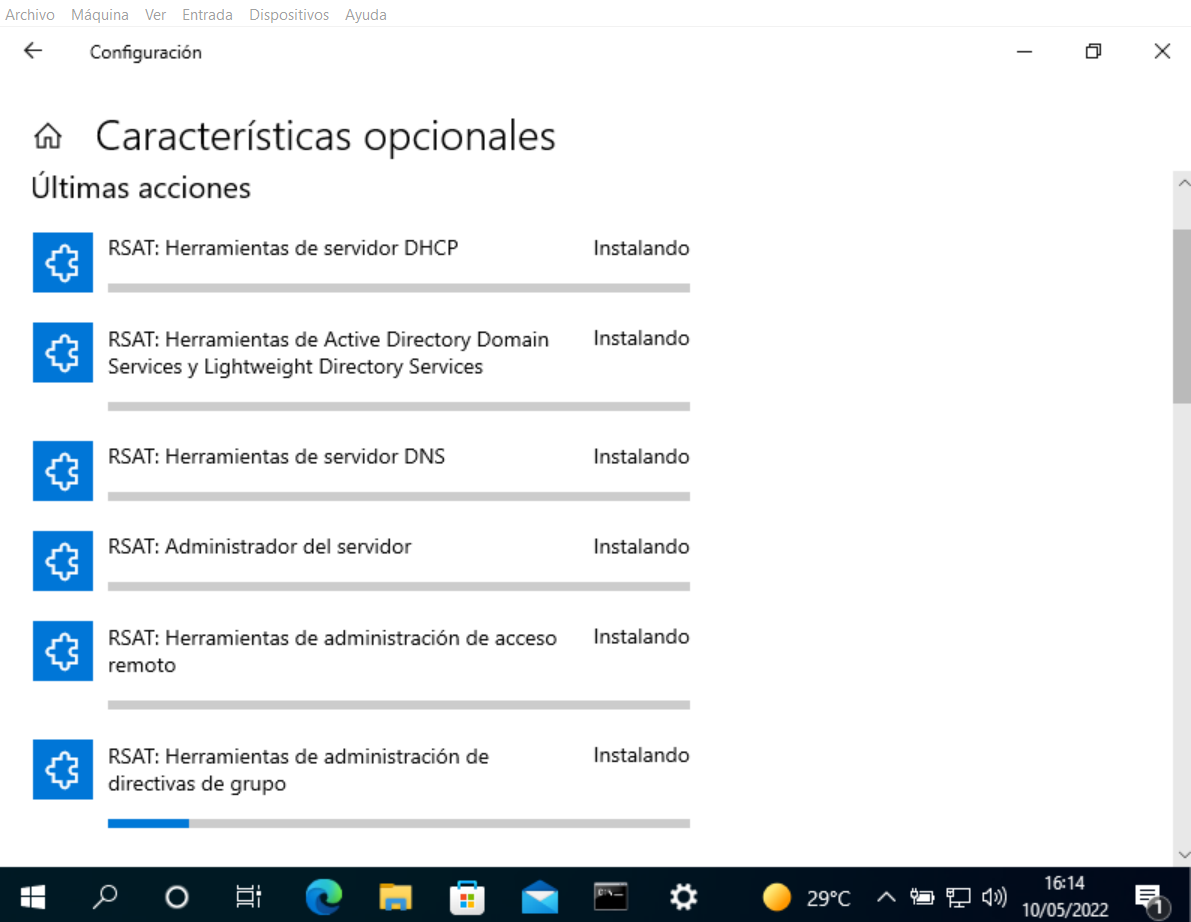

# **CONFIGURACIÓ CLIENT (Ubuntu Desktop)**

## PAS 1: Tenir connexió al Servidor de Directori Actiu des del client Ubuntu Desktop

# **COMANDES DE GESTIÓ DEL DOMINI (Servidor)**

## Servidor Ubuntu: gestió d'UO; grups d'usuaris; usuaris pel nostre domini

Amb l'ajuda de la interfície **samba-tool** podeu gestionar directament els usuaris i grups de domini, la política de grups de domini, els llocs de domini, els serveis DNS, la replicació de domini i altres funcions de domini crítiques.

Nosatres primer provarem algunes funcions més bàsiques:

## Unitats Organitzatives en un Domini

Què són les Unitats Organitzatives?

Una Unitats Organitzatives són objectes contenidors de Active Directory dins d'un Domini, amb els quals podem agrupar multitud d'altres objectes de Active Directory.





Amb les UO podrem generar dins del nostre Domini de Active Directory un arbre de contenidors que representi l'estructura jeràrquica que necessitem en la nostra organització, així podrem administrar millor l'ús els recursos i els comptes.



Dins d'un domini pot haver una o diverses UO, i cada UO pot agrupar qualsevol objecte d'Active Direcotry (grups d'usuaris, usuaris, equips).

Una possible jerarquia seria: **Unitat Organitzativa - Grup d'usuaris - Usuari**

### Creació d'Unitats Organitzatives

In [ ]:
samba-tool ou create 'OU=NOM_UNITAT_ORG,DC=dam,DC=tld' --description='dam.com Main Organizational Unit'

## Grups d'usuaris en un Domini

### Creació de grups d'usuaris

In [ ]:
samba-tool group add NOM_GRUP --groupou='OU=NOM_UNITAT_ORG' --description='IT Technical Support Group'

## Usuaris en un Domini

### Creació d'usuaris

Amb aquesta comanda podeu crear un usuari. La mateixa comanda us demanarà que poseu una contrasenya per l'usuari:

In [ ]:
samba-tool user create NOM_USUARI

In [ ]:
samba-tool user add NOM_USUARI # comanda alternativa

### Llistar tots els usuaris del Domini

In [ ]:
samba-tool user list

### Esborrar usuari del domini

In [ ]:
samba-tool user delete NOM_USUARI

### Canviar contrasenya d'un usuari del Domini

In [ ]:
samba-tool user setpassword NOM_USUARI

### Habilitar o Deshabilitar un usuari del Domini

In [ ]:
samba-tool user disable NOM_USUARI
samba-tool user enable NOM_USUARI